# PR1: Binary classification with Logistic Regression.

In this notebook we are going to learn how to classify image patches as text and non-text objects.

First we are going to see an introduction to Logistic Regression using synthetic data. Then, we will go into a real world problem for text detection. 

## Introduction to Logistic Regression

We are going train a binary classifier using the Logistic Regression model: $h_\theta(\textbf{x}) = \frac{1}{1+e^{-\theta^\intercal \textbf{x}}}$

For this we need to fit the parameters $\theta$ to our dataset by minimizing the cost function $J$:

$\hat{\theta} = \underset{\theta}{\text{minimize}} {1 \over m} \sum_{i=1}^m{-y^{(i)}\log(h_\theta(x^{(i)}) - (1-y^{(i)})\log(1-h_\theta(x^{(i)})}$

where $(x^{(i)},y^{(i)})$ is the i-th training sample, and $m$ is the number of samples in the training set.

We are going to use the Gradient Descent algorithm to solve this minimization problem, in pseudo-code:

repeat until convergence (or max. number of iterations) {

$\theta_j := \theta_j - \alpha \frac{\partial}{\partial \theta_j} J(\theta)$ (for all j)

}

where $\alpha$ is the learning rate, and the partial derivative (the gradient) of the cost function is given by:

$\frac{\partial}{\partial \theta_j} J(\theta) = {1 \over m} \sum_{i=1}^m{(h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)}}$

Notice that the partial derivative of our cost function has the same form as for the Linear Regression cost function, however the difference is in the term $h_\theta(\textbf{x})$, our model. In the case of Logistic Regression $h_\theta(\textbf{x})$ is the sigmoid function of $\theta^\intercal \textbf{x}$.

Thus, the Python code of our **GradientDescent** function is going to be quite the same as for Linear Regression, but calling the **sigmoid** function to evaluate the Logistic Regression model $h_\theta(\textbf{x})$.

In [22]:
import numpy as np

def sigmoid(X):
    '''
    Computes the Sigmoid function of the input argument X.
    '''
    return 1.0/(1+np.exp(-X))


def GradientDescent(x,y,max_iterations=2500, alpha=0.1):
    
    m,n = x.shape # number of samples, number of features

    # y must be a column vector
    y = y.reshape(m,1)
    
    #initialize the parameters
    theta = np.ones(shape=(n,1)) 
    
    # Repeat until convergence (or max_iterations)
    for iteration in range(max_iterations):
        h = sigmoid(np.dot(x,theta))
        error = (h-y)
        gradient = np.dot(x.T , error) / m
        theta = theta - alpha*gradient
    return theta


def classifyVector(X, theta):
    '''
    Evaluate the Logistic Regression model h(x) with theta parameters,
    and returns the predicted label of x.
    '''
    prob = sigmoid(sum(np.dot(X,theta)))
    if prob > 0.5: return 1.0
    else: return 0.0

Let's see how to use this code in a synthetic dataset. First load the data and plot it.

In [23]:
# Load the synthetic dataset

import pickle

with open('./PR1data1.pkl','rb') as f:
 (X,y) = pickle.load(f)

print X.shape, y.shape

(117, 2) (117,)


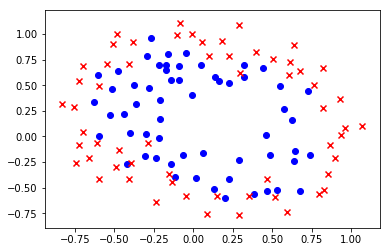

In [24]:
# Plot the data

%matplotlib inline 
import matplotlib.pyplot as plt

plt.scatter(X[y==1, 0], X[y==1, 1], marker='o', c='b') #positive samples
plt.scatter(X[y==0, 0], X[y==0, 1], marker='x', c='r') #negative samples
plt.show()

Now, we train the Logistic Regression classifier and draw its decision boundary in a 2D plot.

Training Accuracy : 0.547008547009


<a list of 1 text.Text objects>

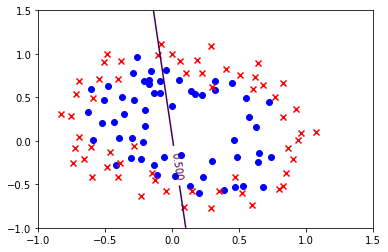

In [25]:
# Append the x_0 column (for the bias term theta_0)
x = np.ones(shape=(X.shape[0], 1))
x = np.append(x,X,axis=1)

#Logistic Regression gradient descent optimization
w = GradientDescent(x,y)

#Evaluate the classifier accuracy in the training data
H = [classifyVector(x[i,:],w) for i in range(x.shape[0])]
print "Training Accuracy : "+str(float(np.sum(H == y)) / y.shape[0])

#Plot data
plt.scatter(X[y==1, 0], X[y==1, 1], marker='o', c='b') #positive samples
plt.scatter(X[y==0, 0], X[y==0, 1], marker='x', c='r') #negative samples

#Plot Decision Boundary
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
z = np.zeros(shape=(len(u), len(v)))
for i in range(len(u)):
    for j in range(len(v)):
        z[i, j] = sigmoid(np.dot(np.array([1,u[i],v[j]]),w))

z = z.T

cs = plt.contour(u, v, z, levels=[0.5])
plt.clabel(cs, inline=1, fontsize=10)

As can be seen in the previous plot the classification boundary with 2 features fits very poorly our data.

One way to fit the data better is to create more features from each data point. We will map the features  into all polynomial terms of $x_1$ and $x_2$ up to the sixth power. 

$MapFeature(x_1,x_2) = [x_1,x_2,x_1^2,x_1x_2,x_2^2,x_1^3, \dots , x_1x_2^5, x_2^6]$

As a result of this mapping, our vector of two features is transformed into a 28-D vector. The Logistic Regression classifier trained on this high dimensional feature space will have a more complex decision boundary (i.e. more degrees of freedom) and will appear nonlinear when drawn in the 2D plot.

In [26]:
def map_feature(x1, x2):
    '''
    Maps 2D features to quadratic features.
    Returns a new feature vector with more features, comprising of
    x1, x2, x1^2, x2^2, x1*x2, x1*x2^2, etc...
    '''
    x1.shape = (x1.size, 1)
    x2.shape = (x2.size, 1)
    degree = 6
    out = np.ones(shape=(x1[:, 0].size, 1))
    
    for i in range(1, degree + 1):
        for j in range(i + 1):
            r = (x1 ** (i - j)) * (x2 ** j)
            out = np.append(out, r, axis=1)

    return out

features = map_feature(X[:,0],X[:,1])
features.shape

(117, 28)

In [27]:
#Logistic Regression gradient descent optimization
w = GradientDescent(features,y)

H = [classifyVector(features[i,:],w) for i in range(features.shape[0])]
print "Training Accuracy : "+str(float(np.sum(H == y)) / y.shape[0])

Training Accuracy : 0.82905982906


<a list of 1 text.Text objects>

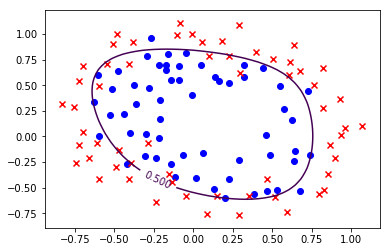

In [28]:
#Plot data
plt.scatter(X[y==1, 0], X[y==1, 1], marker='o', c='b') #positive samples
plt.scatter(X[y==0, 0], X[y==0, 1], marker='x', c='r') #negative samples

#Plot Boundary
u = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 50)
v = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 50)
z = np.zeros(shape=(len(u), len(v)))
for i in range(len(u)):
    for j in range(len(v)):
        z[i, j] = sigmoid(map_feature(np.array(u[i]),np.array(v[j])).dot(w))
        
z = z.T
cs = plt.contour(u, v, z, levels=[0.5])
plt.clabel(cs, inline=1, fontsize=10)


## <font color='red'>Exercise 1: Gradient Descent algorithm convergence</font>

The code of our **GradientDescent** function loops over the max. number of iterations (2500 by default). This does not guarantee that the algorithm has converged to the global optimum of the cost function.

Modify the code of the **GradientDescent** function to loop until convergence **OR** to reach the max. iterations. Try to execute the function for different **max_iterations** and **alpha** values and see if you can make it converge.

What is the best Training Accuracy you can reach? 

Did you find the global minima? How many iterations does it need? With which $\alpha$ value? 

Plot the decision boundary of your classifier.

Hints:

* Reaching the global minima may take a very large number of iterations. Take it easy and do not get stuck here, just give it a try. The important goal of this exercise is to get an intuition of what the gradient descent algorithm is doing, and why it may take so long to reach the global optima.
* Remember that the $\alpha$ parameter controls the step size of Gradient Descent. Try different values. Note that the value of the step size $\alpha$ is allowed to change at every iteration.
* The Numpy function **np.array_equal(A,B)** returns True if arrays A and B are equal.
* To determine whether Gradient Descent has converged, it may help to print out the value of $J(\theta)$ during each iteration.


Training Accuracy : 0.512820512821
Training Accuracy : 0.512820512821
Training Accuracy : 0.512820512821
Training Accuracy : 0.512820512821
Training Accuracy : 0.512820512821
Training Accuracy : 0.512820512821
Training Accuracy : 0.521367521368
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.547008547009
Training Accuracy : 0.555555555556
Training Accuracy : 0.555555555556
Training Accuracy : 0.555555555556
Training Accuracy : 0.555555555556
Training Accuracy : 0.555555555556
Training Accuracy : 0.555555555556
Training Accuracy : 0.547008547009
Training Accuracy : 0.555555555556
Training Accuracy : 0.564102564103
Training Accuracy : 0.581196581197
Training Accuracy : 0.581196581197
Training Accuracy : 0.581196581197
Training Accuracy : 0.589743589744
Training Accuracy : 0.589743589744
Training Accuracy : 0.598290598291
Training Accuracy : 0.598290598291
Training Accuracy : 0.606837606838
Training Accuracy : 

Training Accuracy : 0.495726495726
Training Accuracy : 0.495726495726
Training Accuracy : 0.495726495726
Training Accuracy : 0.495726495726
Training Accuracy : 0.495726495726
Training Accuracy : 0.495726495726
Training Accuracy : 0.495726495726
Training Accuracy : 0.495726495726
Training Accuracy : 0.495726495726
Training Accuracy : 0.495726495726
Training Accuracy : 0.504273504274
Training Accuracy : 0.504273504274
Training Accuracy : 0.504273504274
Training Accuracy : 0.504273504274
Training Accuracy : 0.504273504274
Training Accuracy : 0.504273504274
Training Accuracy : 0.504273504274
Training Accuracy : 0.512820512821
Training Accuracy : 0.512820512821
Training Accuracy : 0.512820512821
Training Accuracy : 0.512820512821
Training Accuracy : 0.504273504274
Training Accuracy : 0.495726495726
Training Accuracy : 0.495726495726
Training Accuracy : 0.495726495726
Training Accuracy : 0.495726495726
Training Accuracy : 0.495726495726
Training Accuracy : 0.495726495726
Training Accuracy : 

Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.521367521368
Training Accuracy : 0.521367521368
Training Accuracy : 0.521367521368
Training Accuracy : 0.521367521368
Training Accuracy : 0.521367521368
Training Accuracy : 0.521367521368
Training Accuracy : 0.521367521368
Training Accuracy : 0.521367521368
Training Accuracy : 0.521367521368
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 

Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 0.529914529915
Training Accuracy : 

<a list of 1 text.Text objects>

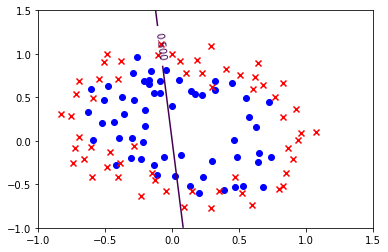

In [57]:
for i in range(1,1000):
    #Logistic Regression gradient descent optimization
    w = GradientDescent(x,y,i)
    #Evaluate the classifier accuracy in the training data
    H = [classifyVector(x[i,:],w) for i in range(x.shape[0])]
    print "Training Accuracy : "+str(float(np.sum(H == y)) / y.shape[0])

#Plot data
plt.scatter(X[y==1, 0], X[y==1, 1], marker='o', c='b') #positive samples
plt.scatter(X[y==0, 0], X[y==0, 1], marker='x', c='r') #negative samples

#Plot Decision Boundary
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
z = np.zeros(shape=(len(u), len(v)))
for i in range(len(u)):
    for j in range(len(v)):
        z[i, j] = sigmoid(np.dot(np.array([1,u[i],v[j]]),w))

z = z.T

cs = plt.contour(u, v, z, levels=[0.5])
plt.clabel(cs, inline=1, fontsize=10)
#NO CONVERGE DE NINGUNA MANERA, MIRAR EL POR QUÉ, TIENE QUE TENER UNA EXPLICACIÓN. 
#EL MÁXIMO VALOR CONSEGUIDO HASTA AHORA ES 0.547008547009, IMPOSIBLE DE MEJORAR.
#PENSAR VARIOS CHECKS

## <font color='red'>Exercise 2: Regularized Logistic Regression</font>

Whether you have found the global minima in the previous exercise, or a very good training accuracy, it is probable that you are overfitting the classifier to this particular training data. If this is the case, the classifier is not going to perform well on unseen data examples.

Regularization is a technique to prevent overfitting.

In order to implement Regularized Logistic Regression we must change only the term of the partial derivative (the gradient) of the cost function:

$\frac{\partial}{\partial \theta_j} J(\theta) = {1 \over m} \sum_{i=1}^m{(h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)}}$.

which in the case of Regularized Logistic Regression is given by:

$\frac{\partial}{\partial \theta_j} J(\theta) = {1 \over m} \sum_{i=1}^m{(h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)}+{\lambda \over m}\theta_j}$

Implement the Regularized Logistic Regression in Python.

# Computer Vision Application: A simple binary classifier for Text vs. Non-text classification.

Our goal is to classify image patches as text and non-text objects.

The roadmap is as follows:

* Learn how to load images as NumPy arrays with SciPy.
* Import the train/test datasets.
* Train and Run the Logistic Regression classifier using two different image features:
 * Raw pixels.
 * Histograms of grey values.
* Evaluate and compare the classifier results using different evaluation measures. 

## Preliminary

Load images, convert to numpy arrays, reshape.

In [8]:
from scipy import misc #micellanea submodule (for imread)

#Load an image example
img = misc.imread('./img_A.pgm')

type(img),img.ndim, img.shape, img.dtype

AttributeError: 'module' object has no attribute 'imread'

In [9]:
import matplotlib.pyplot as plt #matplotlib plotting library

# Display an image
plt.imshow(img, cmap=plt.cm.gray)

NameError: name 'img' is not defined

In [10]:
#reshape image array to a vector (1D array)
img = np.reshape(img,-1)

type(img),img.ndim, img.shape, img.dtype

NameError: name 'img' is not defined

## Data acquisition (Optional)

This part of the notebook deals with loading images from your hard disk and convert them to NumPy arrays. This is going to be our dataset. Images are stored as pgm files but may be in any other image format. 

Since we are going to read near 12000 files from disk, it may take around 20 minutes. If you prefer you can jump to the next section of the notebook and load directly the **raw_pixels_dataset_5980.pklz** file, which already contains the NumPy arrays for the entire dataset. The code is here just in case you are curious about how to convert image files into NumPy arrays, and how the **raw_pixels_dataset_5980.pklz** has been created.

To execute this part of the notebook you must download the **scene_text_dataset.zip** (<font color='red'>~140 Mb</font>) file from the Campus Virtual site and decompress it in the same directory as this python notebook.


In [11]:
from os import listdir #now we will load all images in a given directory

datapath = 'data/characters/icdar/img_ICDAR_train/'

char_raw_pixels = np.array([ np.reshape(misc.imread(datapath+f),-1) for f in listdir(datapath) ])
char_raw_pixels = np.reshape(char_raw_pixels,[-1,1024])

char_raw_pixels.shape

OSError: [Errno 2] No such file or directory: 'data/characters/icdar/img_ICDAR_train/'

In [12]:

datapath = 'data/background/train/'

bg_raw_pixels = np.array([ np.reshape(misc.imread(datapath+f),-1) for f in listdir(datapath) ])
bg_raw_pixels = np.reshape(bg_raw_pixels,[-1,1024])

bg_raw_pixels.shape

OSError: [Errno 2] No such file or directory: 'data/background/train/'

In [13]:
# We want a balanced dataset so we take only the first 5980 background samples
bg_raw_pixels = bg_raw_pixels[0:5980,:]
bg_raw_pixels.shape

NameError: name 'bg_raw_pixels' is not defined

In [14]:
#Visualize. Just to be sure the data is correct

im = char_raw_pixels[1,:]
im = np.reshape(im,[32,32])

plt.subplot(1, 2, 1)
plt.imshow(im, cmap=plt.cm.gray)

im = bg_raw_pixels[1,:]
im = np.reshape(im,[32,32])

plt.subplot(1, 2, 2)
plt.imshow(im, cmap=plt.cm.gray)

NameError: name 'char_raw_pixels' is not defined

In [15]:
train_features = np.append(char_raw_pixels,bg_raw_pixels, axis=0)

char_labels = np.ones([char_raw_pixels.shape[0],1])
bg_labels   = np.zeros([bg_raw_pixels.shape[0],1])

train_labels = np.append(char_labels, bg_labels)

train_features.shape, train_labels.shape

NameError: name 'char_raw_pixels' is not defined

In [16]:
#we now do the same for test data

datapath = 'data/characters/icdar/img_ICDAR_test/'

char_raw_pixels = np.array([ np.reshape(misc.imread(datapath+f),-1) for f in listdir(datapath) ])
char_raw_pixels = np.reshape(char_raw_pixels,[-1,1024])

char_raw_pixels.shape

OSError: [Errno 2] No such file or directory: 'data/characters/icdar/img_ICDAR_test/'

In [17]:
datapath = 'data/background/test/'

bg_raw_pixels = np.array([ np.reshape(misc.imread(datapath+f),-1) for f in listdir(datapath) ])
bg_raw_pixels = np.reshape(bg_raw_pixels,[-1,1024])

bg_raw_pixels.shape

OSError: [Errno 2] No such file or directory: 'data/background/test/'

In [18]:
test_features = np.append(char_raw_pixels,bg_raw_pixels, axis=0)

char_labels = np.ones([char_raw_pixels.shape[0],1])
bg_labels   = np.zeros([bg_raw_pixels.shape[0],1])

test_labels = np.append(char_labels, bg_labels)

test_features.shape, test_labels.shape

NameError: name 'char_raw_pixels' is not defined

In [19]:
#Now we can save all our data as python serialized data, so we do not need to read again image
# files the next time we want execute our classification code

import pickle #module for serialization of python object structure
import gzip   #we can compress our data directly when writting data to a file

with gzip.open('./raw_pixels_dataset_5980.pklz','wb') as f:
 pickle.dump((train_labels,train_features,test_labels,test_features),f,pickle.HIGHEST_PROTOCOL)


NameError: name 'train_labels' is not defined

## Classification using raw pixels as features

In the following we will try how good are the raw pixel features to automatically classify the different classes.

We are going to evaluate classification using Logistic regression

In [20]:
# load the data
import pickle
import gzip

with gzip.open('./raw_pixels_dataset_5980.pklz','rb') as f:
 (train_labels,train_features,test_labels,test_features) = pickle.load(f)

print train_features.shape
print test_features.shape

EOFError: 

In [21]:
#Logistic Regression gradient descent optimization 
w1 = GradientDescent(train_features,train_labels,500) # try only 500 iterations (this is going to take a long time)

# Calculate classification Accuracy in train data
H = [classifyVector(train_features[i,:],w1) for i in range(train_features.shape[0])]
print "Train Accuracy : "+str(float(np.sum(H == train_labels)) / train_labels.shape[0])

# Note: you may want to save the learned parameters here if you do not want 
# to re-train each time you load the notebook!

#import pickle #module for serialization of python object structure
#import gzip   #we can compress our data directly when writting data to a file
#with gzip.open('./raw_pixels_learned_parameters.pklz','wb') as f:
# pickle.dump((w1,f,pickle.HIGHEST_PROTOCOL)

NameError: name 'train_features' is not defined

In [ ]:
# Calculate classification Accuracy in test data
H = [classifyVector(test_features[i,:],w1) for i in range(test_features.shape[0])]
print "Test Accuracy : "+str(float(np.sum(H == test_labels)) / test_labels.shape[0])

# Plot the confusion matrix on test data
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, H)
print 'Confusion matrix:'
print (cm)

# Plot confusion matrix
import matplotlib.pyplot as plt
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Feature extraction

We have seen how using the raw pixels is not a good idea. Intuitively there are two main reasons for the bad performance of our classifier: first, we do not have enough data to train in such a high dimensional space (1024-D), second, the raw pixels do not have enough discriminative power to effectively discriminate over the Text and Non-text examples in our dataset. Notice that a simple 1-pixel shift in one of the examples may produce a very different feature vector.

In Computer Vision (and in Pattern Recognition in general), feature extraction is a procedure to extract pieces of information which are relevant for solving the computational task at hand.
There is a large tradition in designing handcrafted features, that incorporate class prior knowledge, to solve specific problems.

In this part of the notebook we are going to extract simple features: histograms of the intensity values of our images. The intuition is that in text image patches we expect to find bi-level histograms (two opposite dominant colors), because text is by design written with high contrast to its background.

Then we will evaluate how good those features are for  automatically classifying between the two classes (Text/Non-text) using Logistic Regression.


In [ ]:
#For each example we compute the histogram of grey intensity values

new_train_features = np.zeros([train_features.shape[0],8])
for i in range(train_features.shape[0]):
    new_train_features[i,:] = np.histogram(train_features[i,:],8)[0]
    new_train_features[i,:] /= np.sum(new_train_features[i,:]) #Histogram normalization
    
new_test_features = np.zeros([test_features.shape[0],8])
for i in range(test_features.shape[0]):
    new_test_features[i,:] = np.histogram(test_features[i,:],8)[0]
    new_test_features[i,:] /= np.sum(new_test_features[i,:]) #Histogram normalization
    
new_train_features.shape, new_test_features.shape

In [ ]:
#Visualize the histograms of positive/negative samples

plt.subplot(2, 2, 1)
plt.imshow(np.reshape(train_features[1,:],[32,32]), cmap=plt.cm.gray)

plt.subplot(2, 2, 2)
plt.imshow(np.reshape(train_features[5981,:],[32,32]), cmap=plt.cm.gray)

bins = [0,1,2,3,4,5,6,7]

plt.subplot(2, 2, 3)
plt.bar(bins, new_train_features[1,:], align='center')

plt.subplot(2, 2, 4)
plt.bar(bins, new_train_features[5981,:], align='center')

#print train_labels[1],train_labels[5981]

In [ ]:
#Logistic Regression gradient descent optimization
w1 = GradientDescent(new_train_features,train_labels)

H = [classifyVector(new_train_features[i,:],w1) for i in range(new_train_features.shape[0])]
print "Train Accuracy : "+str(float(np.sum(H == train_labels)) / train_labels.shape[0])

In [ ]:
#Calculate classification Accuracy in test data
H = [classifyVector(new_test_features[i,:],w1) for i in range(new_test_features.shape[0])]
print "Test Accuracy : "+str(float(np.sum(H == test_labels)) / test_labels.shape[0])


# confusion matrix on test data
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, H)
print 'Confusion matrix:'
print (cm)

# Plot confusion matrix
import matplotlib.pyplot as plt
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

With the use of Histograms of intensity values we have improved the performance of our classifier by more than 20%!

Notice that this is a very simple feature extraction process, that is not really used in this way in state-of-the-art algorithms. In fact the proposed features are quite weak (as can be seen with the obtained results). However, the idea here is to take conscience that the design of handcrafted features is a possible way of improving the discrimination power of our classifiers.

This experiment also serves to introduce the topic of next Practical (PR2), where we are going to see how it is possible to automatically learn powerful features in an unsupervised way from our training data.

## <font color='red'>Exercise 3: Precision/Recall Curve</font>

Making use the Histogram of intensity values features, evaluate the Precision and Recall measures at different operation points of the classifier. This can be done by changing the 0.5 decision threshold in the ClassifyVector function to a range of values between 0 and 1. Plot the obtained Precision/Recall curve and analyse it.

By looking at the curve: What is the (approximate) Precision to be expected if we want to tune our classifier to a Recall value of 0.9?

## <font color='red'>Exercise 4: Open Exercise</font>

Propose and implement an improvement, or an extra evaluation analysis, for our Text vs. Non-text classifier in its current status.

Some ideas (not a closed list):

* Implement the Stochastic Gradient Descent algorithm. Show how it improves the training time performance.

* Use cross-validation to tune the meta-parameters (max_iterations and learning rate $\alpha$) of Gradient Descent. 

* Other optimization algorithms?

* Evaluate the Test Accuracy as a function of the number of training examples ($m$).

* Use Histogram of Oriented Gradients (HOG) image features. http://scikit-image.org/docs/dev/auto_examples/plot_hog.html

* Improve the Histogram features. E.g. Evaluate the effect of histogram size. Try different number of bins and compare the obatined results (show precision, recall, accuracy). Can you improve the current Test Accuracy? What is the best accuracy you can reach?

* Zoning: compute NxN grey level histograms in a N by N grid of cells over the image patch, and concatenate them to create a new feature.


# Annex: Sliding Window with our Text vs. Non-text classifier

Sliding Window is a common Computer Vision technique used to apply patch-based classifiers into full-size images. The basic idea is to exhaustively evaluate the classifier response in "all" possible sub-windows of the input image.

In [ ]:
from scipy import misc 
#pylab.rcParams['figure.figsize'] = 14, 10.5  # changes the default image size for the notebook
plt.figure(num=None, figsize=(14, 10.5), dpi=80, facecolor='w', edgecolor='k')

# Load an image and plot it
img = misc.imread('img_scene.jpg')
plt.subplot(1, 2, 1)
plt.imshow(img, cmap=plt.cm.gray)

detection_map = np.zeros(shape=img.shape)

win_sizes = (32,64,96)
win_step  = 0.2

for size in win_sizes:
  for x in range(0,img.shape[1]-size,int(size*win_step)):
    for y in range(0,img.shape[0]-size,int(size*win_step)):
        window = img[y:y+size,x:x+size]
        window = misc.imresize(window,(32,32))
        raw_pixels = np.reshape(window,[-1,1024])
        hist_feature = np.histogram(raw_pixels,8)[0]
        hist_feature = hist_feature.astype(np.float32)
        hist_feature /= np.sum(hist_feature.T)
        prob = sigmoid(sum(np.dot(hist_feature,w1)))
        detection_map[y:y+size,x:x+size] += 255*prob
        
plt.subplot(1, 2, 2)
plt.imshow(detection_map,cmap=plt.cm.jet)
